gamma_opt=1.744, eta=1.425e-10
[Ellipse baseline] MSE vs exact: 3.355e-14


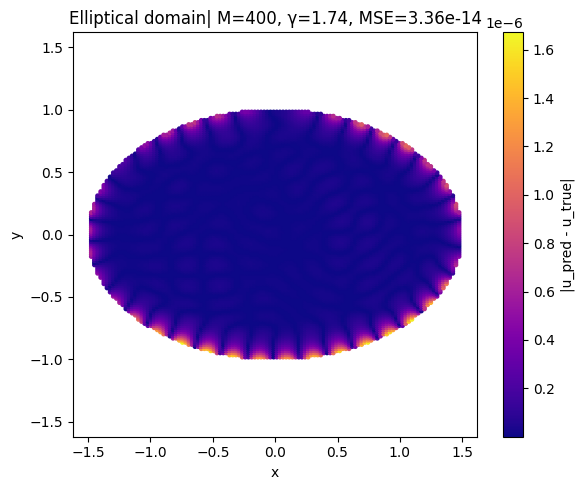

In [6]:
import numpy as np, math, time, matplotlib.pyplot as plt

# ----- Elliptical domain parameters -----
a, b = 1.5, 1.0
pi = math.pi

# ----- PDE setup -----
def u_exact(X):
    x, y = X[:,0], X[:,1]
    return np.sin(pi*x/a) * np.sin(pi*y/b)

def f_rhs(X):
    x, y = X[:,0], X[:,1]
    return (pi**2/a**2 + pi**2/b**2) * np.sin(pi*x/a) * np.sin(pi*y/b)

# ----- Sampling functions -----
def sample_interior_ellipse(n=100):
    xs = np.linspace(-a, a, n)
    ys = np.linspace(-b, b, n)
    X, Y = np.meshgrid(xs, ys)
    mask = (X**2/a**2 + Y**2/b**2 < 1.0)    # 用mask筛选出椭圆内部点
    pts = np.stack([X[mask], Y[mask]], axis=-1)
    return pts

def sample_boundary_ellipse(n_theta=400):   # 边界取点用参数方程
    thetas = np.linspace(0, 2*pi, n_theta, endpoint=False)
    x = a*np.cos(thetas)
    y = b*np.sin(thetas)
    return np.stack([x, y], axis=-1)

# ----- TransNet basis -----
def sigma(s): return np.tanh(s)
def sigma_dd(s): 
    t = np.tanh(s)
    return -2.0 * t * (1.0 - t*t)

def sample_a_r(M, d=2, R=1.6, seed=1234):
    rng = np.random.RandomState(seed)
    A = rng.randn(M, d)
    A /= np.linalg.norm(A, axis=1, keepdims=True)
    r = rng.uniform(-R, R, size=M)
    return A, r

def build_matrices(X_int, X_bd, A, r, gamma):
    S_int = gamma*(X_int @ A.T + r[None,:])
    S_bd  = gamma*(X_bd  @ A.T + r[None,:])
    Psi_int = sigma(S_int)
    Psi_bd  = sigma(S_bd)
    Psi_dd_int = (gamma**2) * sigma_dd(S_int)
    F_int = -Psi_dd_int * np.sum(A**2, axis=1)[None,:]  # Laplacian term
    return F_int, Psi_bd

def solve_alpha_ls(F_int, Psi_bd, f_int, g_bd, w_L=1.0, w_B=10.0, reg=1e-8):
    A_big = np.vstack([w_L*F_int, w_B*Psi_bd])
    rhs = np.concatenate([w_L*f_int, w_B*g_bd])
    AtA = A_big.T @ A_big + reg*np.eye(A_big.shape[1])
    Atb = A_big.T @ rhs
    return np.linalg.solve(AtA, Atb)

def u_pred_numpy(X, A, r, gamma, alpha):
    S = gamma*(X @ A.T + r[None,:])
    return sigma(S) @ alpha

# ----- Golden section search -----
def eta_of_gamma(gamma, X_int, X_bd, f_int, g_bd, A, r):
    F_int, Psi_bd = build_matrices(X_int, X_bd, A, r, gamma)
    alpha = solve_alpha_ls(F_int, Psi_bd, f_int, g_bd)
    e_int = F_int @ alpha - f_int
    e_bd  = Psi_bd @ alpha - g_bd
    mse = np.mean(e_int**2) + 10*np.mean(e_bd**2)
    return (mse, alpha)

def golden_search(func, a, b, tol=1e-3, max_iters=80):
    phi = (1 + 5**0.5)/2
    invphi = 1/phi
    c = b - invphi*(b-a)
    d = a + invphi*(b-a)
    fc = func(c)
    fd = func(d)
    for _ in range(max_iters):
        if abs(b-a) < tol: break
        if fc[0] < fd[0]:
            b, d, fd = d, c, fc
            c = b - invphi*(b-a); fc = func(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi*(b-a); fd = func(d)
    return (c, fc) if fc[0] < fd[0] else (d, fd)

# ----- Main TransNet solve -----
def run_transnet_ellipse(M=400):
    X_int = sample_interior_ellipse(120)
    X_bd  = sample_boundary_ellipse(400)
    f_int = f_rhs(X_int)
    g_bd  = u_exact(X_bd)
    A, r = sample_a_r(M, R=1.6)
    gamma_opt, (eta, alpha_opt) = golden_search(lambda g: eta_of_gamma(g, X_int, X_bd, f_int, g_bd, A, r),
                                                1e-2, 80.0)
    print(f"gamma_opt={gamma_opt:.3f}, eta={eta:.3e}")
    return A, r, gamma_opt, alpha_opt, X_int, X_bd

# ----- Run experiment -----
A, r, gamma_opt, alpha_opt, X_int, X_bd = run_transnet_ellipse(M=400)

# Evaluate error
u_pred = u_pred_numpy(X_int, A, r, gamma_opt, alpha_opt)
u_true = u_exact(X_int)
mse = np.mean((u_pred - u_true)**2)
print(f"[Ellipse baseline] MSE vs exact: {mse:.3e}")

# Plot comparison
plt.figure(figsize=(6,5))
plt.scatter(X_int[:,0], X_int[:,1], c=np.abs(u_pred - u_true), s=6, cmap='plasma')
plt.colorbar(label='|u_pred - u_true|')
plt.title(f'Elliptical domain| M={400}, γ={gamma_opt:.2f}, MSE={mse:.2e}')
plt.xlabel('x'); plt.ylabel('y')
plt.axis('equal'); plt.tight_layout(); plt.show()
